In [1]:
# Import Dependencies

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import PIL.Image

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
batch_size = 15
image_size = 300
data_dir = '/content/drive/MyDrive/Datasets/pokemon_pictures'

['.config', 'pokemon_testing.zip', 'drive', '.ipynb_checkpoints', 'pokemon_pictures.zip', 'sample_data']


In [3]:
t_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    batch_size=batch_size,
    color_mode='rgb',
    image_size=(image_size, image_size),
    validation_split=0.35,
    subset="training",
    seed=123
)

v_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    batch_size=batch_size,
    color_mode='rgb',
    image_size=(image_size, image_size),
    validation_split=0.35,
    subset="training",
    seed=123
)

Found 6312 files belonging to 138 classes.
Using 4103 files for training.
Found 6312 files belonging to 138 classes.
Using 4103 files for training.


In [4]:
class_names = t_dataset.class_names
print(class_names)

['Abra', 'Aerodactyl', 'Alakazam', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Golbat', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk', 'Nidoking', 'Nidoqueen', 'Nidorina', 'Nidorino', 'Ninetales', 'Oddish', 'Omanyte', 'Omastar', 'Onix', 'P

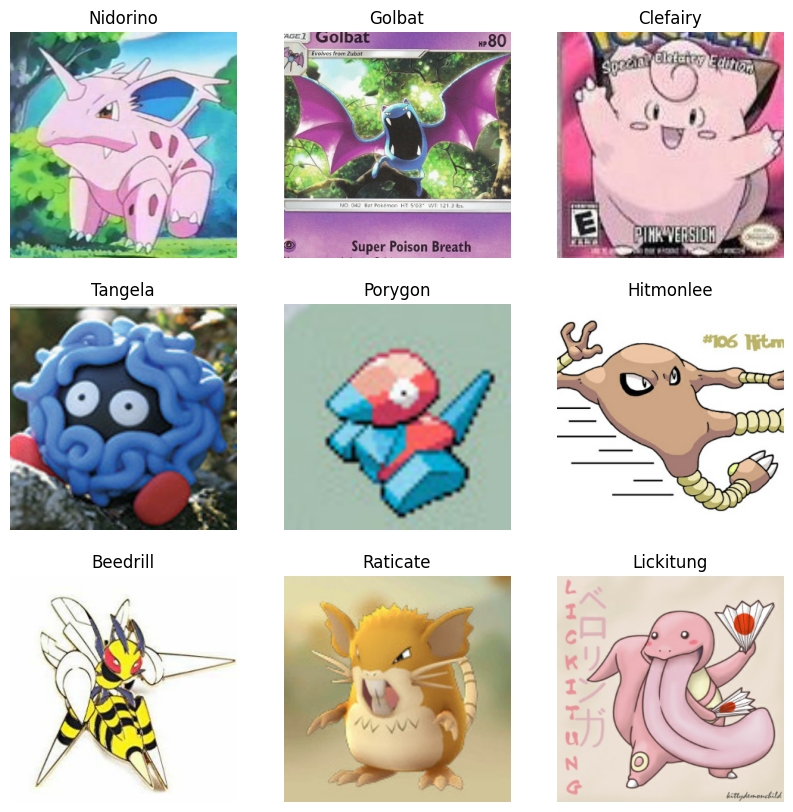

In [5]:
# Visualise data

plt.figure(figsize=(10, 10))
for images,labels in t_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [23]:
for image_batch, labels_batch in t_dataset:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

# Theresult is a batch of 15 250x250 images with RGB channeling

(15, 300, 300, 3)
(15,)


In [24]:
AUTOTUNE = tf.data.AUTOTUNE

# Keeps images in memory to prevent bottlenecking
t_dataset = t_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# OVerlaps datapreprocessing and model execution in training
v_dataset = v_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Despite obtaining high training and validation scores, when a testing score is introduced the model does not seem to be able to do well. Given that in each class there aren't actually that many images we make use of data augmentation to generate additional training data.

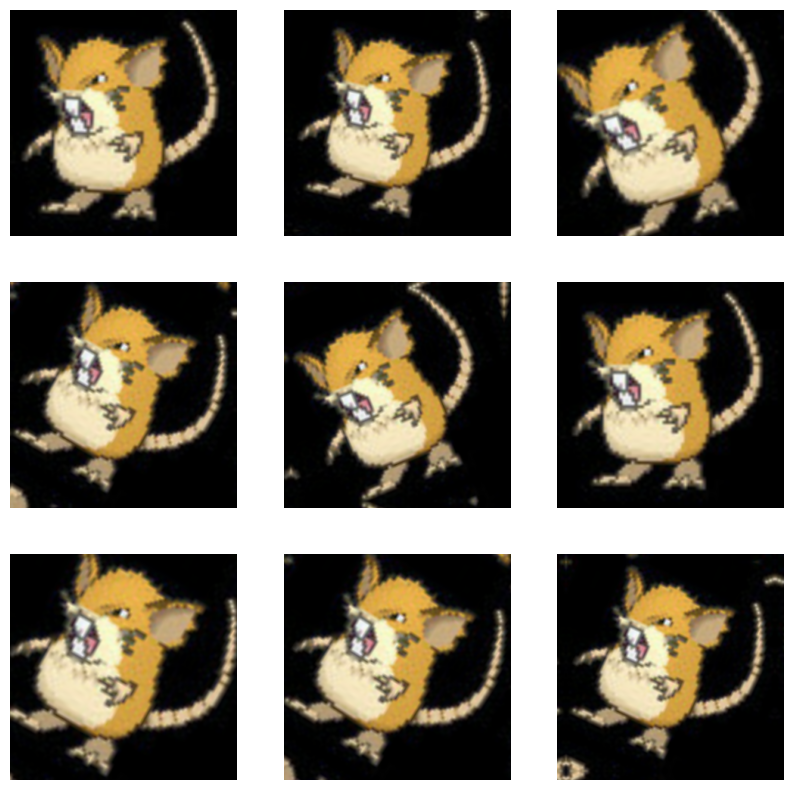

In [25]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",
                      input_shape=(image_size, image_size, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

plt.figure(figsize=(10,10))
for images, _ in t_dataset.take(1):
  for i in range (9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

The model was too inaccurate even after adding augmentation, and while running more epochs slightly increased the accuracy the model began overfitting. By introducing dropout I am to negate this.

In [17]:
# Create model

num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(image_size, image_size, 3)), # standardize data
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [18]:
# Compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 300, 300, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 300, 300, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 150, 150, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                  

In [19]:
# Train the model
epochs = 19
history = model.fit(
    t_dataset,
    validation_data = v_dataset,
    epochs=epochs
)

Epoch 1/19
274/274 [==============================] - 106s 223ms/step - loss: 4.7221 - accuracy: 0.0346 - val_loss: 4.0241 - val_accuracy: 0.0943
Epoch 2/19
274/274 [==============================] - 14s 49ms/step - loss: 3.6043 - accuracy: 0.1450 - val_loss: 3.0464 - val_accuracy: 0.2566
Epoch 3/19
274/274 [==============================] - 13s 47ms/step - loss: 2.9700 - accuracy: 0.2481 - val_loss: 2.4684 - val_accuracy: 0.3519
Epoch 4/19
274/274 [==============================] - 13s 46ms/step - loss: 2.5683 - accuracy: 0.3302 - val_loss: 2.1815 - val_accuracy: 0.4216
Epoch 5/19
274/274 [==============================] - 13s 47ms/step - loss: 2.2539 - accuracy: 0.3958 - val_loss: 1.7815 - val_accuracy: 0.5316
Epoch 6/19
274/274 [==============================] - 13s 46ms/step - loss: 2.0054 - accuracy: 0.4631 - val_loss: 1.5737 - val_accuracy: 0.5796
Epoch 7/19
274/274 [==============================] - 13s 46ms/step - loss: 1.8009 - accuracy: 0.5069 - val_loss: 1.3371 - val_accurac

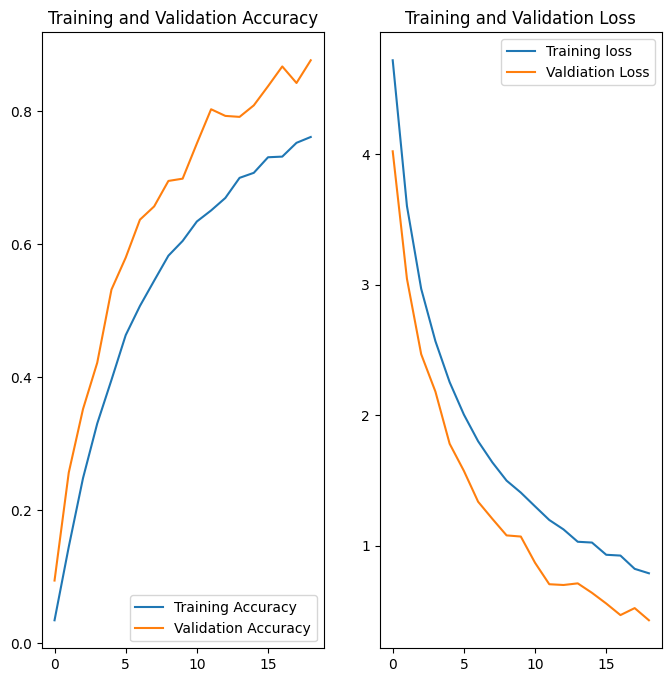

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training loss')
plt.plot(epochs_range, val_loss, label='Valdiation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The results showed a high training and validation accuracy. Note that the validation accuracy was higher than the training accuracy. I've decided to therefore omit measures to prevent overfitting as overfitting does not appear to be present from the graphs.

In [21]:
# Predictions - upload a file of a Pokemon then modify the code



# Cut the name of the file to just the name of the Pokemon
def getPokemonName(filename):
  dot = filename.index('.')
  numIndex = None

  for i in range(len(filename)-(len(filename)-dot)):
    if filename[dot-i-1].isnumeric():
      numIndex = dot-i-1
    else:
      break

  if numIndex:
    return filename[:numIndex]
  return filename[:dot]

def predict(prediction_path):
  img = tf.keras.utils.load_img(
      prediction_path,
      target_size=(image_size, image_size)
  )

  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print("{}, {:.2f}%".format(class_names[np.argmax(score)], 100 * np.max(score)))
  return class_names[np.argmax(score)]

def run_tests():
  testing_path = '/content/drive/MyDrive/Datasets/pokemon_testing/'
  num_correct = 0

  for filename in os.listdir(testing_path):
    guess = predict(testing_path+filename)
    print(guess, filename)
    if guess.lower() == getPokemonName(filename):
      num_correct+=1
  return num_correct/len(os.listdir(testing_path))*100

In [22]:
run_tests()

1/1 [==============================] - 1s 888ms/step
Ninetales, 34.40%
Ninetales geodude3.jpeg
1/1 [==============================] - 1s 581ms/step
Graveler, 68.77%
Graveler geodude2.jpeg
1/1 [==============================] - 1s 520ms/step
Gengar, 86.54%
Gengar gengar.png
1/1 [==============================] - 0s 488ms/step
Wigglytuff, 46.35%
Wigglytuff wigglytuff2.png
1/1 [==============================] - 1s 531ms/step
Eevee, 89.23%
Eevee evee.jpeg
1/1 [==============================] - 1s 533ms/step
Wigglytuff, 82.98%
Wigglytuff wigglytuff.png
1/1 [==============================] - 1s 522ms/step
Geodude, 98.96%
Geodude geodude4.png
1/1 [==============================] - 1s 586ms/step
Snorlax, 83.25%
Snorlax snorlax.jpeg
1/1 [==============================] - 1s 615ms/step
Eevee, 92.06%
Eevee evee3.jpeg
1/1 [==============================] - 1s 590ms/step
Golbat, 54.08%
Golbat gastly2.jpeg
1/1 [==============================] - 1s 527ms/step
Dragonite, 79.92%
Dragonite pikachu6.jpeg

38.46153846153847

Finally we obtained a score of about 38% which is reasonably good considering I choose to use a testing dataset without 'frontpage' images of Pokemon. Furthermore the Pokemon dataset contained a large number of diverse classes, so given that a score of 38% is significantly higher than a random guess, for my first deep learning project the result is satisfactory!